In [1]:
!unzip -q '/content/drive/My Drive/drone_dataset.zip' -d '/content/'

In [ ]:
!pip install torch==1.5.0 torchvision==0.6.0 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
!pip install albumentations==0.4.5

In [2]:
from data_loader import drone_dataloader

In [ ]:
%matplotlib inline

In [3]:
import torch
from timeit import default_timer as timer
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image

In [ ]:
trainloader, testloader, class_names, trainset = drone_dataloader()

CUDA Available? True


In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.3749, 0.4123, 0.4352])
    std = np.array([0.3326, 0.3393, 0.3740])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    # fig = plt.figure(figsize = (15, 15))
    if title is not None:
        plt.title(title)
    plt.imshow(inp)

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(trainloader))

In [ ]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs[8:16])

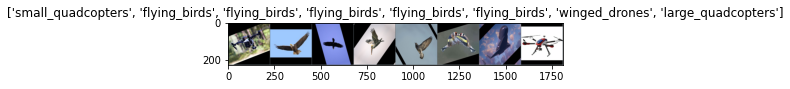

In [ ]:
imshow(out, title=[class_names[x] for x in classes[8:16]])

In [ ]:
model = torchvision.models.mobilenet_v2(pretrained=True)

In [ ]:
model

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [ ]:
# Freeze early layers
for param in model.parameters():
    param.requires_grad = False

In [ ]:
model.classifier[1] = nn.Linear(1280, 4)

In [ ]:
model.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(1280, 512),
            nn.Linear(512, 4),
        )

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

2,228,996 total parameters.
2,228,996 training parameters.


In [ ]:
from torchsummary import summary
model = model.to('cuda')
summary(model, input_size=(3, 224, 224), batch_size=128, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [128, 32, 112, 112]             864
       BatchNorm2d-2        [128, 32, 112, 112]              64
             ReLU6-3        [128, 32, 112, 112]               0
            Conv2d-4        [128, 32, 112, 112]             288
       BatchNorm2d-5        [128, 32, 112, 112]              64
             ReLU6-6        [128, 32, 112, 112]               0
            Conv2d-7        [128, 16, 112, 112]             512
       BatchNorm2d-8        [128, 16, 112, 112]              32
  InvertedResidual-9        [128, 16, 112, 112]               0
           Conv2d-10        [128, 96, 112, 112]           1,536
      BatchNorm2d-11        [128, 96, 112, 112]             192
            ReLU6-12        [128, 96, 112, 112]               0
           Conv2d-13          [128, 96, 56, 56]             864
      BatchNorm2d-14          [128, 96,

In [ ]:
model.class_to_idx = trainset.class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}
list(model.idx_to_class.items())[:10]

[(0, 'flying_birds'),
 (1, 'large_quadcopters'),
 (2, 'small_quadcopters'),
 (3, 'winged_drones')]

In [ ]:
train_on_gpu = True

In [ ]:
def train(model,
          criterion,
          optimizer,
          scheduler,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=20,
          print_every=2):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )
                    print('lr: ', optimizer.param_groups[0]['lr'])
                scheduler.step(valid_loss)
                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, patience=5)

In [ ]:
model, history = train(
    model,
    criterion,
    optimizer,
    scheduler,
    trainloader,
    testloader,
    save_file_name='mobilenet_v2_2.pth',
    max_epochs_stop=10,
    n_epochs=30,
    print_every=1)

Starting Training from Scratch.


Epoch: 0 	Training Loss: 0.5487 	Validation Loss: 0.4124
		Training Accuracy: 77.80%	 Validation Accuracy: 83.00%
lr:  0.01

Epoch: 1 	Training Loss: 0.3962 	Validation Loss: 0.3929
		Training Accuracy: 84.12%	 Validation Accuracy: 84.60%
lr:  0.01

Epoch: 2 	Training Loss: 0.3470 	Validation Loss: 0.3634
		Training Accuracy: 86.15%	 Validation Accuracy: 85.57%
lr:  0.01

Epoch: 3 	Training Loss: 0.3213 	Validation Loss: 0.3921
		Training Accuracy: 86.99%	 Validation Accuracy: 83.61%
lr:  0.01

Epoch: 4 	Training Loss: 0.2997 	Validation Loss: 0.3858
		Training Accuracy: 87.87%	 Validation Accuracy: 85.84%
lr:  0.01

Epoch: 5 	Training Loss: 0.2802 	Validation Loss: 0.3486
		Training Accuracy: 88.97%	 Validation Accuracy: 86.94%
lr:  0.01

Epoch: 6 	Training Loss: 0.2534 	Validation Loss: 0.3527
		Training Accuracy: 90.08%	 Validation Accuracy: 86.49%
lr:  0.01

Epoch: 7 	Training Loss: 0.2424 	Validation Loss: 0.3588
		Training Accuracy: 90.18%	 Valid

KeyboardInterrupt: ignored

In [ ]:
model, history = train(
    model,
    criterion,
    optimizer,
    scheduler,
    trainloader,
    testloader,
    save_file_name='mobilenet_v2_3.pth',
    max_epochs_stop=10,
    n_epochs=30,
    print_every=1)

Starting Training from Scratch.


Epoch: 0 	Training Loss: 0.5364 	Validation Loss: 0.5121
		Training Accuracy: 77.66%	 Validation Accuracy: 81.41%
lr:  0.01

Epoch: 1 	Training Loss: 0.3964 	Validation Loss: 0.4062
		Training Accuracy: 84.63%	 Validation Accuracy: 83.93%
lr:  0.01

Epoch: 2 	Training Loss: 0.3632 	Validation Loss: 0.3713
		Training Accuracy: 85.73%	 Validation Accuracy: 85.37%
lr:  0.01

Epoch: 3 	Training Loss: 0.3240 	Validation Loss: 0.3365
		Training Accuracy: 87.08%	 Validation Accuracy: 86.65%
lr:  0.01

Epoch: 4 	Training Loss: 0.2941 	Validation Loss: 0.3394
		Training Accuracy: 88.50%	 Validation Accuracy: 86.67%
lr:  0.01

Epoch: 5 	Training Loss: 0.2823 	Validation Loss: 0.3652
		Training Accuracy: 88.87%	 Validation Accuracy: 86.56%
lr:  0.01

Epoch: 6 	Training Loss: 0.2617 	Validation Loss: 0.3477
		Training Accuracy: 89.62%	 Validation Accuracy: 87.07%
lr:  0.01

Epoch: 7 	Training Loss: 0.2543 	Validation Loss: 0.3658
		Training Accuracy: 89.81%	 Valid

In [ ]:
def process_image(image_path):
    """Process an image path into a PyTorch tensor"""

    image = Image.open(image_path)
    # Resize
    img = image.resize((256, 256))

    # Center crop
    width = 256
    height = 256
    new_width = 224
    new_height = 224

    left = (width - new_width) / 2
    top = (height - new_height) / 2
    right = (width + new_width) / 2
    bottom = (height + new_height) / 2
    img = img.crop((left, top, right, bottom))

    # Convert to numpy, transpose color dimension and normalize
    img = np.array(img).transpose((2, 0, 1)) / 256

    # Standardization
    means = np.array([0.3749, 0.4123, 0.4352]).reshape((3, 1, 1))
    stds = np.array([0.3326, 0.3393, 0.3740]).reshape((3, 1, 1))

    img = img - means
    img = img / stds

    img_tensor = torch.Tensor(img)

    return img_tensor

In [ ]:
def predict(image_path, model, topk=4):
    """Make a prediction for an image using a trained model

    Params
    --------
        image_path (str): filename of the image
        model (PyTorch model): trained model for inference
        topk (int): number of top predictions to return

    Returns

    """
    real_class = image_path.split('/')[-2]

    # Convert to pytorch tensor
    img_tensor = process_image(image_path)

    # Resize
    if train_on_gpu:
        img_tensor = img_tensor.view(1, 3, 224, 224).cuda()
    else:
        img_tensor = img_tensor.view(1, 3, 224, 224)

    # Set to evaluation
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(img_tensor)
        # ps = torch.exp(out)

        # Find the topk predictions
        topk, topclass = out.topk(topk, dim=1)

        # Extract the actual classes and probabilities
        top_classes = [
            model.idx_to_class[class_] for class_ in topclass.cpu().numpy()[0]
        ]
        top_p = topk.cpu().numpy()[0]

        return img_tensor.cpu().squeeze(), top_p, top_classes, real_class

In [ ]:
x = process_image('/content/drone_dataset/val/small_quadcopters/114.jpg')
x.shape

torch.Size([3, 224, 224])

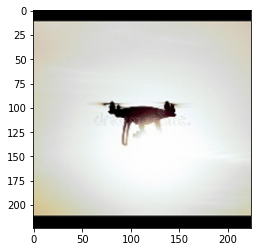

In [ ]:
imshow(x)

In [ ]:
img, top_p, top_classes, real_class = predict('/content/drone_dataset/val/small_quadcopters/114.jpg', model)
img.shape

torch.Size([3, 224, 224])

In [ ]:
top_p, top_classes, real_class

(array([ 6.6377864 ,  0.22320807, -0.9166422 , -5.0955663 ], dtype=float32),
 ['small_quadcopters', 'large_quadcopters', 'flying_birds', 'winged_drones'],
 'small_quadcopters')

In [ ]:
model.load_state_dict(torch.load('/content/mobilenet_v2_2.pth'))

<All keys matched successfully>

In [ ]:
model.to('cpu')
model.eval()
traced_model = torch.jit.trace(model, torch.randn(1, 3, 224, 224))

In [ ]:
traced_model.save('mobilenet_v2_drone.pt')

In [ ]:
# torch.jit.save(traced_model, 'mobilenet_v2_drone_jit.pt')

Text(0.5, 1.0, 'Training and Validation Losses')

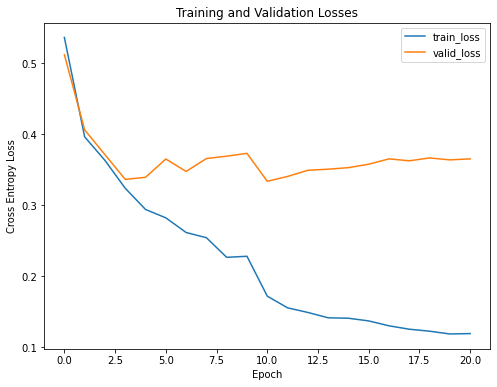

In [ ]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Training and Validation Losses')

In [ ]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c][:16], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Training and Validation Losses')

Text(0.5, 1.0, 'Training and Validation Accuracy')

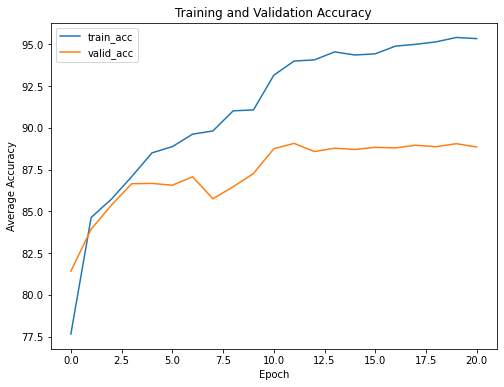

In [ ]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

Text(0.5, 1.0, 'Training and Validation Accuracy')

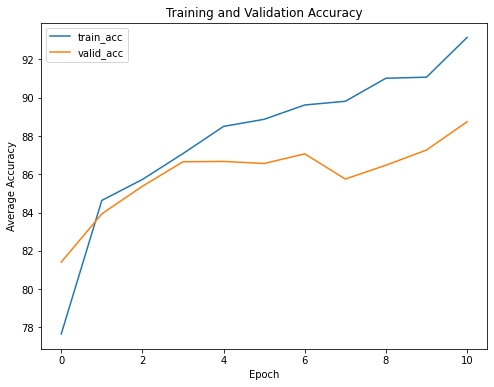

In [ ]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c][:11], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

In [ ]:
import torch

In [ ]:
model = torch.jit.load('mobilenet_v2_drone.pt')

In [ ]:
!pip install torch==1.5.0

  Using cached https://files.pythonhosted.org/packages/13/70/54e9fb010fe1547bc4774716f11ececb81ae5b306c05f090f4461ee13205/torch-1.5.0-cp36-cp36m-manylinux1_x86_64.whl
ERROR: torchvision 0.7.0+cu101 has requirement torch==1.6.0, but you'll have torch 1.5.0 which is incompatible.
  Found existing installation: torch 1.6.0
    Uninstalling torch-1.6.0:
      Successfully uninstalled torch-1.6.0


In [ ]:
torch.__version__

'1.6.0'

In [ ]:
model

RecursiveScriptModule(
  original_name=MobileNetV2
  (features): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(
      original_name=ConvBNReLU
      (0): RecursiveScriptModule(original_name=Conv2d)
      (1): RecursiveScriptModule(original_name=BatchNorm2d)
      (2): RecursiveScriptModule(original_name=ReLU6)
    )
    (1): RecursiveScriptModule(
      original_name=InvertedResidual
      (conv): RecursiveScriptModule(
        original_name=Sequential
        (0): RecursiveScriptModule(
          original_name=ConvBNReLU
          (0): RecursiveScriptModule(original_name=Conv2d)
          (1): RecursiveScriptModule(original_name=BatchNorm2d)
          (2): RecursiveScriptModule(original_name=ReLU6)
        )
        (1): RecursiveScriptModule(original_name=Conv2d)
        (2): RecursiveScriptModule(original_name=BatchNorm2d)
      )
    )
    (2): RecursiveScriptModule(
      original_name=InvertedResidual
      (conv): RecursiveScriptModule(
     

In [ ]:
# model.to('cpu')

In [ ]:
model.save('mobilenet_v2_drone1.pt')

# Finding Misclassifications

In [4]:
trainloader, testloader, class_names, trainset = drone_dataloader()

CUDA Available? False


In [5]:
model  = torch.jit.load('mobilenet_v2_drone.pt')

In [14]:
device = 'cpu'

In [60]:
def find_misclassified(model, test_loader):
    misclassified_images_fb = []
    misclassified_images_lq = []
    misclassified_images_sq = []
    misclassified_images_wd = []
    model.eval()
    with torch.no_grad():
        for data, target in test_loader:
            # data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            is_correct = pred.eq(target.view_as(pred))
            misclassified_inds = (is_correct == 0).nonzero()[:, 0]
            for mis_ind in misclassified_inds:
                ac = target[mis_ind].cpu().numpy()
                if ac == 0:
                    if len(misclassified_images_fb) < 10:
                        misclassified_images_fb.append({
                            "target": target[mis_ind].cpu().numpy(),
                            "pred": pred[mis_ind][0].cpu().numpy(),
                            "img":  np.transpose(data[mis_ind].cpu().clone().numpy(), (1, 2, 0))
                        })
                if ac == 1:
                    if len(misclassified_images_lq) < 10:
                        misclassified_images_lq.append({
                            "target": target[mis_ind].cpu().numpy(),
                            "pred": pred[mis_ind][0].cpu().numpy(),
                            "img":  np.transpose(data[mis_ind].cpu().clone().numpy(), (1, 2, 0))
                        })
                if ac == 2:
                    if len(misclassified_images_sq) < 10:
                        misclassified_images_sq.append({
                            "target": target[mis_ind].cpu().numpy(),
                            "pred": pred[mis_ind][0].cpu().numpy(),
                            "img":  np.transpose(data[mis_ind].cpu().clone().numpy(), (1, 2, 0))
                        })
                if ac == 3:
                    if len(misclassified_images_wd) < 10:
                        misclassified_images_wd.append({
                            "target": target[mis_ind].cpu().numpy(),
                            "pred": pred[mis_ind][0].cpu().numpy(),
                            "img":  np.transpose(data[mis_ind].cpu().clone().numpy(), (1, 2, 0))
                        })
                if len(misclassified_images_fb) == 10 \
                and len(misclassified_images_lq) == 10 \
                and len(misclassified_images_sq) == 10 \
                and len(misclassified_images_wd) == 10:
                    return [misclassified_images_fb, misclassified_images_lq, misclassified_images_sq, misclassified_images_wd]

                

In [61]:
misclassified = find_misclassified(model, testloader)

In [70]:
mean = np.array([0.3749, 0.4123, 0.4352])
std = np.array([0.3326, 0.3393, 0.3740])

In [67]:
def denormalize(image, mean, std, out_type='np_array'):
    """Un-normalize a given image,i.e., tensor or numpy array
    Args:
        image: A 3-D numpy array or 3-D tensor.
            If tensor, it should be in CPU.
        mean: Mean value. It can be a single value or
            a tuple with 3 values (one for each channel).
        std: Standard deviation value. It can be a single value or
            a tuple with 3 values (one for each channel).
        out_type: Out type of the normalized image.
            `np_array` -> then numpy array is returned
            `tensor` ->  then torch tensor is returned.
    """

    if type(image) == torch.Tensor:
        image = np.transpose(image.clone().numpy(), (1, 2, 0))

    normal_image = image * std + mean
    if out_type == 'tensor':
        return torch.Tensor(np.transpose(normal_image, (2, 0, 1)))
    elif out_type == 'np_array':
        return normal_image
    return None

In [82]:
def plot_misclassified(img_name, mean, std, misclassified_images, classes):
    plt.figure(figsize=(10, 10))
    num_of_images = len(misclassified_images)
    for index in range(1, num_of_images + 1):
        img = denormalize(misclassified_images[index - 1]["img"], mean, std, )  # Denormalize
        plt.subplot(5, 2, index)
        plt.axis('off')
        plt.imshow(img)
        # plt.imshow(np.transpose(img, (1, 2, 0)))
        plt.title("Predicted: %s\nActual: %s" % (
            classes[misclassified_images[index - 1]["pred"]],
            classes[misclassified_images[index - 1]["target"]]))

    plt.tight_layout()
    plt.savefig(img_name)
    plt.show()

In [71]:
classes = ['Flying Birds', 'Large Quadcopters', 'Small Quadcopters', 'Winged Drones']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

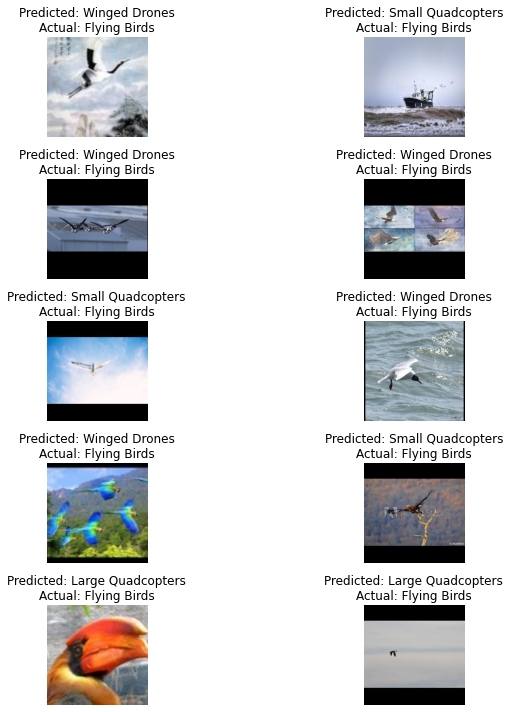

In [88]:
#Flying Birds
plot_misclassified('fb.jpg', mean, std, misclassified[0], classes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

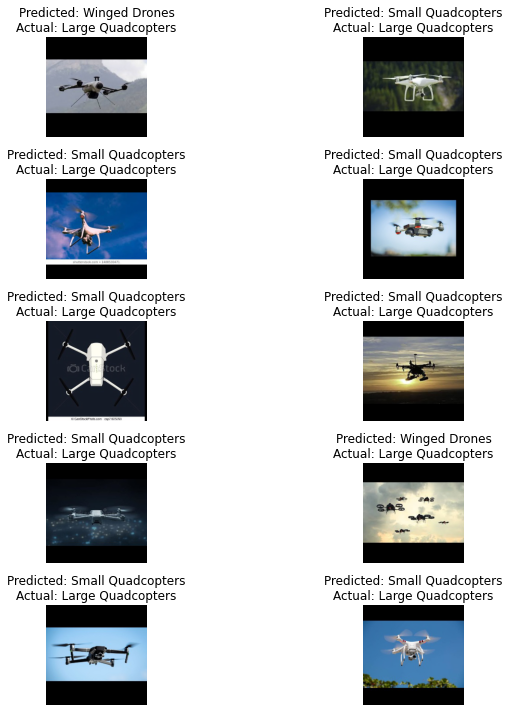

In [85]:
#Large Quadcopters
plot_misclassified('lq.jpg', mean, std, misclassified[1], classes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

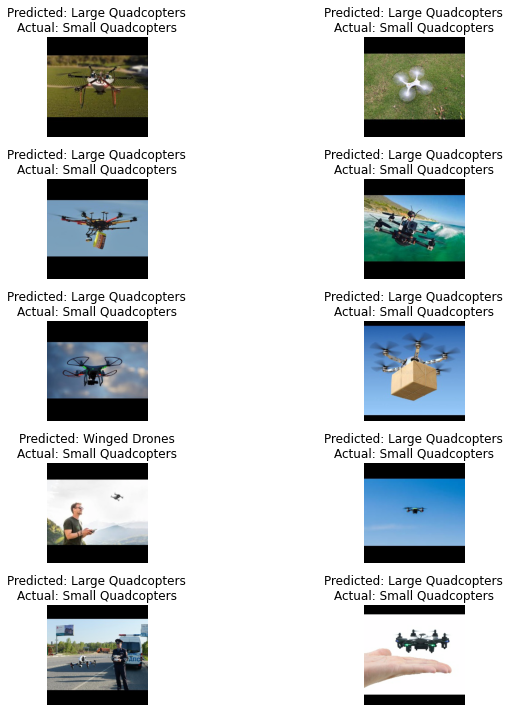

In [89]:
#Small Quadcopters
plot_misclassified('sq.jpg', mean, std, misclassified[2], classes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

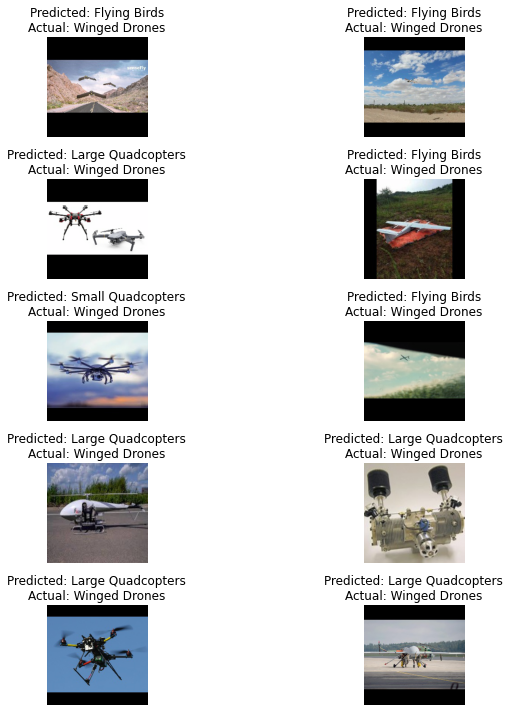

In [90]:
#Winged Drones
plot_misclassified('wd.jpg', mean, std, misclassified[3], classes)